In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random

In [ ]:
# Load dataset
df = pd.read_csv(r"/kaggle/input/faces-age-detection-dataset/faces/train.csv")


In [ ]:
# Map class labels to numeric values
age_group = {"YOUNG": 0, "MIDDLE": 1, "OLD": 2}
df['target'] = df['Class'].map(age_group)


In [ ]:
# Load and resize images
folder_path = '/kaggle/input/faces-age-detection-dataset/faces/Train'
df['image'] = df['ID'].apply(lambda id: cv2.resize(plt.imread(os.path.join(folder_path, id)), (180, 180)))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1317s 3s/step - accuracy: 0.5643 - loss: 1.1841 - val_accuracy: 0.7416 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1283s 3s/step - accuracy: 0.7425 - loss: 0.6321 - val_accuracy: 0.7712 - val_loss: 0.5491 - learning_rate: 0.0010
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1298s 3s/step - accuracy: 0.8164 - loss: 0.4704 - val_accuracy: 0.7865 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1332s 3s/step - accuracy: 0.8609 - loss: 0.3601 - val_accuracy: 0.7825 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1288s 3s/step - accuracy: 0.8812 - loss: 0.3080 - val_accuracy: 0.7777 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 6/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1284s 3s/step - accuracy: 0.9165 - loss: 0.2238 - val_accuracy: 0.8041 - val_loss: 0.5336 - learning_rate: 2.0000e-04
Epoch 7/10
498/498 ━━

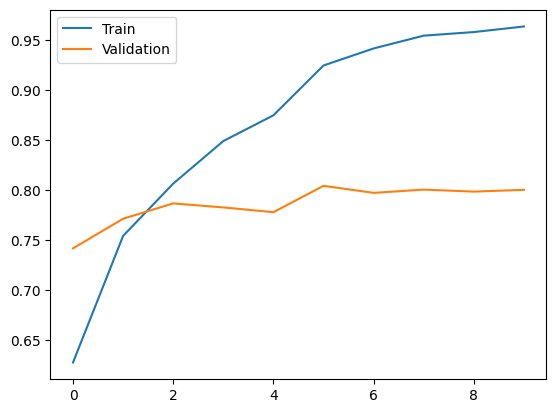

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class: MIDDLE


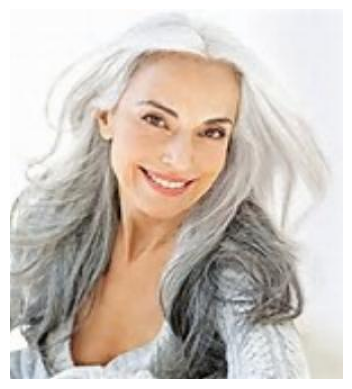

In [1]:
# Data Augmentation using ImageDataGenerator
imggen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.4, 0.55),
    horizontal_flip=True,
    width_shift_range=0.22
)

# Generate augmented images for training, avoiding manual augmentation
augmented_images = np.stack(df['image'].values)
augmented_labels = df['target'].values

# Shuffle the dataset
aug_imgs, class_list = shuffle(augmented_images, augmented_labels, random_state=42)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(aug_imgs, class_list, test_size=0.2, random_state=42)

# Set input shape for ResNet50
input_shape = (180, 180, 3)

# Load pre-trained ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in resnet_base.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    resnet_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

# Plot training history
plt.plot(history.history["accuracy"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.legend(loc='upper left')
plt.show()

# Save the model
model.save(r"/kaggle/working/Age-Detector-Model-95.keras")

# Test Data Processing and Prediction
def preprocess_test_image(image):
    image_resized = cv2.resize(image, (180, 180)) / 255.0
    return np.expand_dims(image_resized, axis=0)

def predict_class(model, image):
    processed_img = preprocess_test_image(image)
    pred_probas = model.predict(processed_img)
    pred_class = pred_probas.argmax()
    return list(age_group.keys())[pred_class]

# Load test image and model
test_path = f"{os.getcwd()}/../input/faces-age-detection-dataset/faces_02/part3"
test_files = os.listdir(test_path)

test_x = plt.imread(os.path.join(test_path, test_files[3200]))

plt.axis("off")
plt.imshow(test_x)
l_model = load_model(r"/kaggle/working/Age-Detector-Model-95.keras")
pred = predict_class(l_model, test_x)
print(f"Class: {pred}")
